In [1]:
import re
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import os
from math import inf

# Discrete Unit Disk Cover Problem
Johana A • Emma A

In [2]:
class Point:

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __repr__(self):
        return '(%s,%s)' % (self.x, self.y)
       
    def __lt__(self, other):
         return self.x < other.x

class Circle:

    def __init__(self,x,y):
        self.x = x
        self.y = y 
        self.r = 1
        
    def __repr__(self):
        return  '(%s, %s)' % (self.x, self.y) 
    
    def __lt__(self, other):
         return self.x < other.x 
    
    def covers(self, point):
        if (point.x - self.x)**2 + (point.y - self.y)**2 <= 1 :
            return True
        return False

class DUDC:
    def __init__(self):
        self.P = set() # set of points
        self.Q = set() # set of unit circles
        self.num_P = 0
        self.num_Q = 0
        self.oneDimension = True

    def read_file(self, pathname):
        
        with open(pathname, 'r') as f:
            
            # Get all lines to be read
            lines = f.readlines()
            
            CirclesData = lines[0].split(";")
            PointsData = lines[1].split(";")
            for d in CirclesData:
                coordinates = re.findall(r"[-+]?\d*\.?\d+|[-+]?\d+", d) # regex to find all numbers in a string 
                uc = Circle(float(coordinates[0]), float(coordinates[1]))
                if uc.y != 0 :
                    self.oneDimension = False
                self.Q.add(uc)
                self.num_Q = self.num_Q + 1
            
            for d in PointsData:
                coordinates = re.findall(r"[-+]?\d*\.?\d+|[-+]?\d+", d)
                p = Point(float(coordinates[0]),float(coordinates[1]))
                if p.y != 0 :
                    self.oneDimension = False
                self.P.add(p)
                self.num_P = self.num_P + 1 
            #print("numUnitCircles", self.num_Q)    
            #print("numPoints",self.num_P)
            
    def __repr__(self):
        return  f'{self.P}, {self.Q}'
    
    def fig(self, solution = []):
        plt.clf()
        plt.axis("equal")
        for e in self.P:
            plt.scatter(e.x, e.y,marker = '+',c='black', zorder = 2)
        for e in self.Q:
            if e in solution :
                plt.scatter(e.x, e.y,marker = 'o',c='blue', zorder = 1)
                circle = plt.Circle((e.x, e.y), 1, color = 'blue', alpha = 0.1, zorder = 0)
                plt.gcf().gca().add_artist(circle);
                
            else :
                plt.scatter(e.x, e.y,marker = 'o',c='red', zorder = 1)
                circle = plt.Circle((e.x, e.y), 1, color = 'red', alpha = 0.1, zorder = 0)
                plt.gcf().gca().add_artist(circle);
  
        plt.xlabel('coordonnee X')
        plt.ylabel('coordonnee Y')
        plt.title('DUDC Problem')
        return plt
    

## Greedy algorithm for 1 dimension

In [3]:
def disk_cover_1D(P, Q):
    Points = sorted(list(P))
    Circles = sorted(list(Q))
    Qstar= set()
    
    circle_pointer = 0
    
    #while there remains points to be covered
    while (len(Points)!=0) :
        leftpoint = Points[0] #we select the leftmost point

        #we find the first circle that covers this point
        while circle_pointer < len(Circles) :
            candidate = Circles[circle_pointer]
            if candidate.covers(leftpoint):
                break
            circle_pointer += 1
        
        #if we haven't found a circle that covers leftpoint, the problem has no solution
        if circle_pointer >= len(Circles):
            print("This problem has no solution.")
            Qstar.clear()
            break
        
        #find the rightmost circle that covers leftpoint
        while circle_pointer < len(Circles) - 1 and Circles[circle_pointer + 1].covers(leftpoint):
            circle_pointer += 1
            candidate = Circles[circle_pointer]
        
        #add this circle to the solution
        Qstar.add(candidate)
        
        #remove points covered by this circle from the list of points to cover
        for p in Points:
            if candidate.covers(p):
                Points.remove(p)
                
    return Qstar

ex3.txt
This problem is in 2D.

ex2.txt


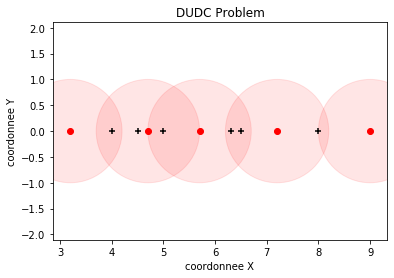

Solution :


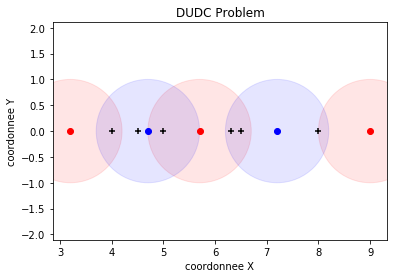

ex1.txt


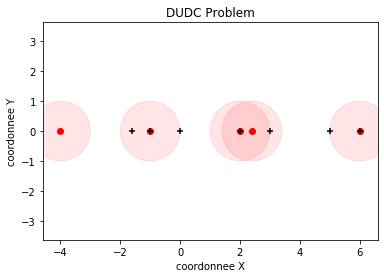

Solution :


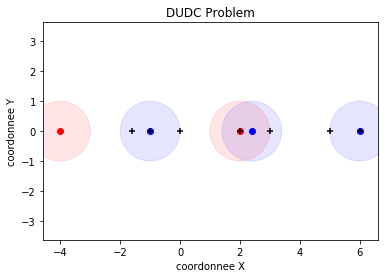

ex5.txt
This problem is in 2D.

ex4.txt
This problem is in 2D.

ex6.txt
This problem is in 2D.

ex7.txt
This problem is in 2D.



In [4]:
files = os.listdir("DUDC_examples")

for file in files:
    pb = DUDC()
    print(file)
    pb.read_file("DUDC_examples/" + file)
    if pb.oneDimension :
        
        fig = pb.fig()
        title = file[:-4] + "_original.png"
        fig.savefig("Output_examples/" + title)
        fig.show()
        Qstar = disk_cover_1D(pb.P, pb.Q)
        
        
        if len(Qstar)>0 :
            print("Solution :")
            res = pb.fig(Qstar)
            t = file[:-4] + "_solution.png"
            res.savefig("Output_examples/" + t)
            res.show()
            
    else :
        print("This problem is in 2D.\n")

## Branch and Bound for 2 dimensions

In [5]:
class Node:
        
    def __init__(self, parent = None, left_child = None, right_child = None, circle = None,
                 LB = inf, taken_circles = [], passed_circles = [], remaining_points = []):
        self.parent = parent
        self.left_child = left_child
        self.right_child = right_child
        self.LB = LB # lower bound 
        self.circle = circle #branching circle
        self.taken_circles = taken_circles #circles already in node's solution
        self.passed_circles = passed_circles #circles not in node's solution
        self.remaining_points = remaining_points #points left to be covered

                  
    def estimate_lb(self, sorted_circles): # estimation of the minimum number of circles to take to cover all points
        nb_to_be_covered = len(self.remaining_points)
        estimation = len(self.taken_circles)

        for circle in sorted_circles :
            if not circle in self.taken_circles and not circle in self.passed_circles :
                estimation += 1
                nb_to_be_covered -= circle[1]
            if nb_to_be_covered <= 0 :
                break
        
        if nb_to_be_covered > 0 :
            self.LB = inf
        else :
            self.LB= estimation

    def branch(self, next_circle, sorted_circles):
        #compute number of remaining points for left child
        to_be_covered = []
        for point in self.remaining_points :
            if not self.circle[0].covers(point) :
                to_be_covered.append(point)
            
        #create left child and right child
        self.left_child = Node(parent = self, circle = next_circle, taken_circles = self.taken_circles + [self.circle], 
                               passed_circles = self.passed_circles, remaining_points = to_be_covered)
        self.left_child.estimate_lb(sorted_circles)
        self.right_child = Node(parent = self, circle = next_circle, taken_circles = self.taken_circles, 
                                passed_circles = self.passed_circles + [self.circle], remaining_points = self.remaining_points)
        self.right_child.estimate_lb(sorted_circles)
        

In [6]:
 def disk_cover_2D(DUDC):
        
    circles= DUDC.Q
    points = DUDC.P
    Qstar = set()
        
    #get list of circles ordered by number of covered points in descending order
    ordered_circles = []
    for circle in circles :
        count = 0
        for point in points :
            if circle.covers(point):
                count += 1
        ordered_circles.append([circle, count])
    ordered_circles.sort(key = lambda x : x[1], reverse = True)
    
    #initialize b&b tree
    root = Node(circle = ordered_circles[0], remaining_points = list(points))
    root.estimate_lb(sorted_circles = ordered_circles)
    
    if root.LB == inf :
        print("This problem has no solution.\n")
        return Qstar
    
    to_be_visited = [root]
    solution_node = None
    
    while(len(to_be_visited) > 0) :
        #choose node with lowest lower bound to visit
        node = min(to_be_visited, key = lambda x : x.LB)
        to_be_visited.remove(node)
        
        #if we reached a node for which all points are covered, it's a solution
        if len(node.remaining_points) == 0:
            if solution_node == None or node.LB < solution_node.LB :
                solution_node = node
        
        #branch if possible and node is not already a solution
        if node.circle != None and len(node.remaining_points) > 0:
            index = ordered_circles.index(node.circle) + 1
            if index >= len(ordered_circles):
                next_circle = None
            else :
                next_circle = ordered_circles[index]
            node.branch(next_circle, ordered_circles)
            
            if node.left_child.LB != inf:
                to_be_visited.append(node.left_child)
            if node.right_child.LB != inf:
                to_be_visited.append(node.right_child)
        
        #ignore nodes with a worse bound than the best solution found so far
        if solution_node != None:
            for n in to_be_visited:
                if n.LB >= solution_node.LB :
                    to_be_visited.remove(n)
            
    if solution_node == None:
        print("This problem has no solution.\n")
    else :
        for circle in solution_node.taken_circles :
            Qstar.add(circle[0])
    return Qstar

ex3.txt


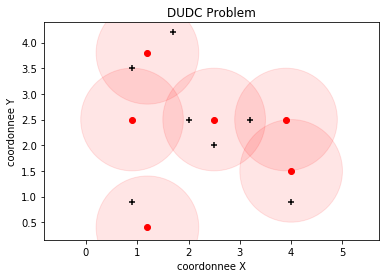

Solution :


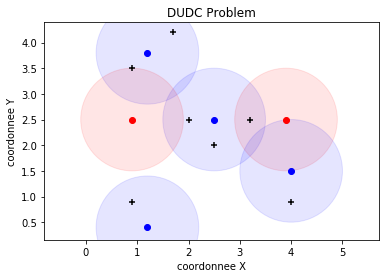

ex2.txt
This problem is in 1D.

ex1.txt
This problem is in 1D.

ex5.txt


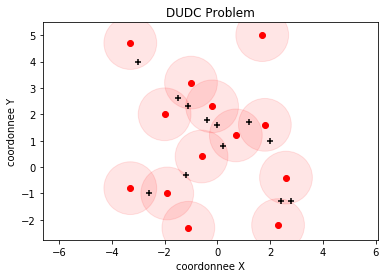

Solution :


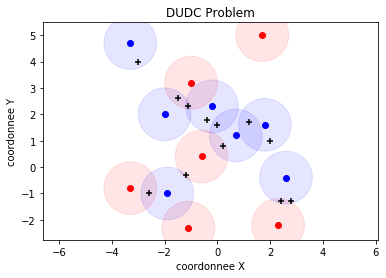

ex4.txt


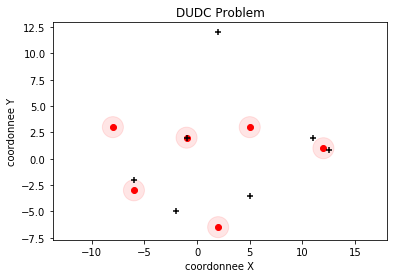

This problem has no solution.

ex6.txt


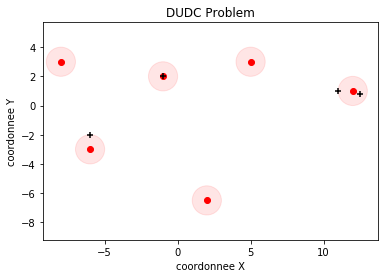

Solution :


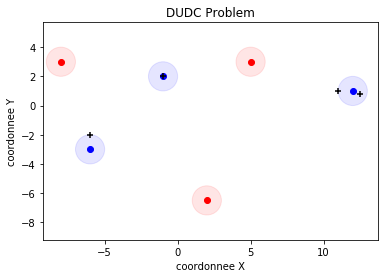

ex7.txt


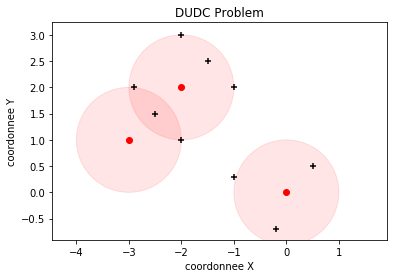

This problem has no solution.



In [7]:
files = os.listdir("DUDC_examples")

for file in files:
    pb = DUDC()
    print(file)
    pb.read_file("DUDC_examples/" + file)
    if not pb.oneDimension :
        
        fig = pb.fig()
        title = file[:-4] + "_original.png"
        fig.savefig("Output_examples/" + title)
        fig.show()
        Qstar = disk_cover_2D(pb)
        
        
        if len(Qstar)>0 :
            print("Solution :")
            res = pb.fig(Qstar)
            t = file[:-4] + "_solution.png"
            res.savefig("Output_examples/" + t)
            res.show()
            
    else :
        print("This problem is in 1D.\n")